## Packages

In [ ]:
!git clone https://github.com/OSUPCVLab/SegFormer3D.git
%cd SegFormer3D

!pip install -r requirements.txt
!pip install monai accelerate termcolor

In [1]:
!pip install safetensors>=0.4.1
!pip install transformers -U

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from monai.transforms import Transform, MapTransform

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Adjust SegFormer3D package to handle BraTs 2023 data

In [4]:
!mkdir -p /content/drive/MyDrive/BraTs/brats2023-processed
!mkdir -p /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data
!mkdir -p /content/SegFormer3D/experiments/brats_2023/my_experiment

In [5]:
%%writefile /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data/brats2023_seg_preprocess.py
import os
import torch
import nibabel
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
from sklearn.preprocessing import MinMaxScaler
from monai.transforms import Orientation, EnsureType, Transform
from monai.utils.enums import TransformBackends
from monai.config.type_definitions import NdarrayOrTensor
from monai.data import MetaTensor

class ConvertToMultiChannelBasedOnBrats2023Classes(Transform):
    backend = [TransformBackends.TORCH, TransformBackends.NUMPY]

    def __call__(self, img: NdarrayOrTensor) -> NdarrayOrTensor:
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)
        result = [(img == 1), (img == 2), (img == 3)]
        return torch.stack(result, dim=0) if isinstance(img, torch.Tensor) else np.stack(result, axis=0)

class Brats2023Preprocess:
    def __init__(self, train_folder_dir, save_dir):
        self.save_dir = save_dir
        self.train_folder_dir = train_folder_dir
        assert os.path.exists(self.train_folder_dir), f"Training folder not found: {self.train_folder_dir}"
        self.case_name = next(os.walk(self.train_folder_dir), (None, None, []))[1]
        assert len(self.case_name) > 0, "No cases found in the directory!"
        self.MRI_TYPE = ["t1n", "t1c", "t2f", "t2w", "seg"]

    def __len__(self):
        return len(self.case_name)

    def get_modality_fp(self, case_name, mri_type):
        return os.path.join(self.train_folder_dir, case_name, case_name + f"-{mri_type}.nii")

    def load_nifti(self, fp):
        nifti_data = nibabel.load(fp)
        nifti_scan = nifti_data.get_fdata()
        affine = nifti_data.affine
        return nifti_scan, affine

    def normalize(self, x):
        scaler = MinMaxScaler(feature_range=(0, 1))
        normalized_1D_array = scaler.fit_transform(x.reshape(-1, x.shape[-1]))
        return normalized_1D_array.reshape(x.shape)

    def orient(self, x):
        return Orientation(axcodes="RAS")(x)

    def detach_meta(self, x):
        return EnsureType(data_type="numpy", track_meta=False)(x)

    def crop_zero_pixels(self, x):
        return x[:, 56:184, 56:184, 13:141]

    def preprocess_brats_modality(self, data_fp, is_label=False):
        try:
            data, affine = self.load_nifti(data_fp)
            if is_label:
                data = data.astype(np.uint8)
                data = ConvertToMultiChannelBasedOnBrats2023Classes()(data)
            else:
                data = self.normalize(data)
                data = data[np.newaxis, ...]
            data = MetaTensor(data, affine)
            data = self.orient(data)
            data = self.detach_meta(data)
            data = self.crop_zero_pixels(data)
            return data
        except Exception as e:
            print(f"Error processing file {data_fp}: {e}")
            return None

    def __getitem__(self, idx):
        case_name = self.case_name[idx]
        modalities = []
        for mri_type in self.MRI_TYPE:
            data_fp = self.get_modality_fp(case_name, mri_type)
            modality = self.preprocess_brats_modality(data_fp, is_label=(mri_type == "seg"))
            if modality is not None:
                if mri_type == "seg":
                    modality = modality.swapaxes(1, 3)
                else:
                    modality = modality.swapaxes(1, 3)
                modalities.append(modality)
        return np.concatenate(modalities[:-1], axis=0), modalities[-1], case_name

    def __call__(self):
        print("Started preprocessing BraTS2023...")
        with Pool(processes=4) as pool:
            list(tqdm(pool.imap(self.process, range(self.__len__())), total=self.__len__()))
        print("Finished preprocessing BraTS2023.")

    def process(self, idx):
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        try:
            modalities, label, case_name = self.__getitem__(idx)
            data_save_path = os.path.join(self.save_dir, case_name)
            if not os.path.exists(data_save_path):
                os.makedirs(data_save_path)
            modalities_fn = os.path.join(data_save_path, f"{case_name}_modalities.pt")
            torch.save(modalities, modalities_fn)
            label_fn = os.path.join(data_save_path, f"{case_name}_label.pt")
            torch.save(label, label_fn)
        except Exception as e:
            print(f"Failed to process {self.case_name[idx]}: {e}")

if __name__ == "__main__":
    preprocessor = Brats2023Preprocess(
        train_folder_dir="/content/drive/MyDrive/BraTs/brats2023-training",
        save_dir="/content/drive/MyDrive/BraTs/brats2023-processed"
    )
    preprocessor()

Writing /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data/brats2023_seg_preprocess.py


In [6]:
%%writefile /content/SegFormer3D/dataloaders/brats2023_seg.py
import os
import torch
import pandas as pd
from torch.utils.data import Dataset

class Brats2023Dataset(Dataset):
    def __init__(self, root_dir, is_train=True, transform=None, fold_id=None):
        super().__init__()
        csv_name = "train.csv" if is_train else "validation.csv"
        csv_fp = os.path.join(root_dir, csv_name)
        assert os.path.exists(csv_fp), f"CSV file not found: {csv_fp}"

        self.csv = pd.read_csv(csv_fp)
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        data_path = self.csv["data_path"][idx]
        case_name = self.csv["case_name"][idx]

        volume_fp = os.path.join(data_path, f"{case_name}_modalities.pt")
        label_fp = os.path.join(data_path, f"{case_name}_label.pt")

        volume = torch.tensor(torch.load(volume_fp)).float()
        label = torch.tensor(torch.load(label_fp)).float()

        data = {"image": volume, "label": label}

        if self.transform:
            data = self.transform(data)

        return data

Writing /content/SegFormer3D/dataloaders/brats2023_seg.py


In [7]:
%%writefile /content/SegFormer3D/dataloaders/build_dataset.py
import sys
from typing import Dict
from monai.data import DataLoader
from augmentations.augmentations import build_augmentations

def build_dataset(dataset_type: str, dataset_args: Dict):
    if dataset_type == "brats2023_seg":
        from .brats2023_seg import Brats2023Dataset
        dataset = Brats2023Dataset(
            root_dir=dataset_args["root"],
            is_train=dataset_args["train"],
            transform=build_augmentations(dataset_args["train"]),
            fold_id=dataset_args["fold_id"],
        )
        return dataset
    else:
        raise ValueError("only brats2023 segmentation is currently supported!")

def build_dataloader(dataset, dataloader_args: Dict, config: Dict = None, train: bool = True) -> DataLoader:
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=dataloader_args["batch_size"],
        shuffle=dataloader_args["shuffle"],
        num_workers=dataloader_args["num_workers"],
        drop_last=dataloader_args["drop_last"],
        pin_memory=True,
    )
    return dataloader

Overwriting /content/SegFormer3D/dataloaders/build_dataset.py


In [20]:
%%writefile /content/SegFormer3D/experiments/brats_2023/my_experiment/config.yaml
# wandb parameters
project: segfmr3d
wandb_parameters:
  mode: "offline" # set this to "online" if you want to log to wandb
  entity: pcvlab
  group: brats2023
  name: segformer3d_adamw_batch2_diceloss
  resume: False
  tags: ["pcvlab", "dice", "b0_model", "adamw"]

# model parameters
model_name: segformer3d
model_parameters:
  in_channels: 4
  sr_ratios: [4, 2, 1, 1]
  embed_dims: [32, 64, 160, 256]
  patch_kernel_size: [7, 3, 3, 3]
  patch_stride: [4, 2, 2, 2]
  patch_padding: [3, 1, 1, 1]
  mlp_ratios: [4, 4, 4, 4]
  num_heads: [1, 2, 5, 8]
  depths: [2, 2, 2, 2]
  num_classes: 3
  decoder_dropout: 0.0
  decoder_head_embedding_dim: 256

# loss function
loss_fn:
  loss_type: "dice"
  loss_args: None

# optimizer
optimizer:
  optimizer_type: "adamw"
  optimizer_args:
    lr: 0.0001
    weight_decay: 0.01

# schedulers
warmup_scheduler:
  enabled: True # should be always true
  warmup_epochs: 20

train_scheduler:
  scheduler_type: 'cosine_annealing_wr'
  scheduler_args:
    t_0_epochs: 400
    t_mult: 1
    min_lr: 0.000006

# (Not fully implemented yet) exponential moving average
ema:
  enabled: False
  ema_decay: 0.999
  val_ema_every: 1

sliding_window_inference:
  sw_batch_size: 4
  roi: [128, 128, 128]

# gradient clipping (not implemented yet)
clip_gradients:
  enabled: False
  clip_gradients_value: 0.1

# training hyperparameters
training_parameters:
  seed: 42
  num_epochs: 800
  cutoff_epoch: 400
  load_optimizer: True
  print_every: 100
  calculate_metrics: True
  grad_accumulate_steps: 4 # default: 1
  checkpoint_save_dir: "model_checkpoints/best_dice_checkpoint"
  load_checkpoint: # not implemented yet
    load_full_checkpoint: False
    load_model_only: False
    load_checkpoint_path: None

# dataset args
dataset_parameters:
  dataset_type: "brats2023_seg"
  train_dataset_args:
    root: "../../../data/brats2023_seg"
    train: True
    fold_id: null

  val_dataset_args:
    root: "../../../data/brats2023_seg"
    train: False
    fold_id: null

  train_dataloader_args:
    batch_size: 4
    shuffle: True
    num_workers: 8
    drop_last: True

  val_dataloader_args:
    batch_size: 2
    shuffle: False
    num_workers: 6
    drop_last: False

Overwriting /content/SegFormer3D/experiments/brats_2023/my_experiment/config.yaml


## Data preparation

### Pre-process data

In [9]:
!python /content/SegFormer3D/data/brats2023_seg/brats2023_raw_data/brats2023_seg_preprocess.py

2024-07-10 10:38:32.621952: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 10:38:32.622004: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 10:38:32.623707: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 10:38:33.652181: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Started preprocessing BraTS2023...
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadloc

### Check preprocessed data

In [11]:
# Load a sample preprocessed file
patient_id = "BraTS-MET-00292-000"
sample_modalities_path = f"/content/drive/MyDrive/BraTs/brats2023-processed/{patient_id}/{patient_id}_modalities.pt"
sample_label_path = f"/content/drive/MyDrive/BraTs/brats2023-processed/{patient_id}/{patient_id}_label.pt"

modalities = torch.load(sample_modalities_path)
label = torch.load(sample_label_path)

print("Shape of modalities tensor:", modalities.shape)
print("Shape of label tensor:", label.shape)

# Convert the label to a PyTorch tensor if it's not already one
if not isinstance(label, torch.Tensor):
    label = torch.tensor(label)

print("Unique classes in label tensor:", torch.unique(label))

Shape of modalities tensor: (4, 128, 128, 128)
Shape of label tensor: (3, 128, 128, 128)
Unique classes in label tensor: tensor([False,  True])


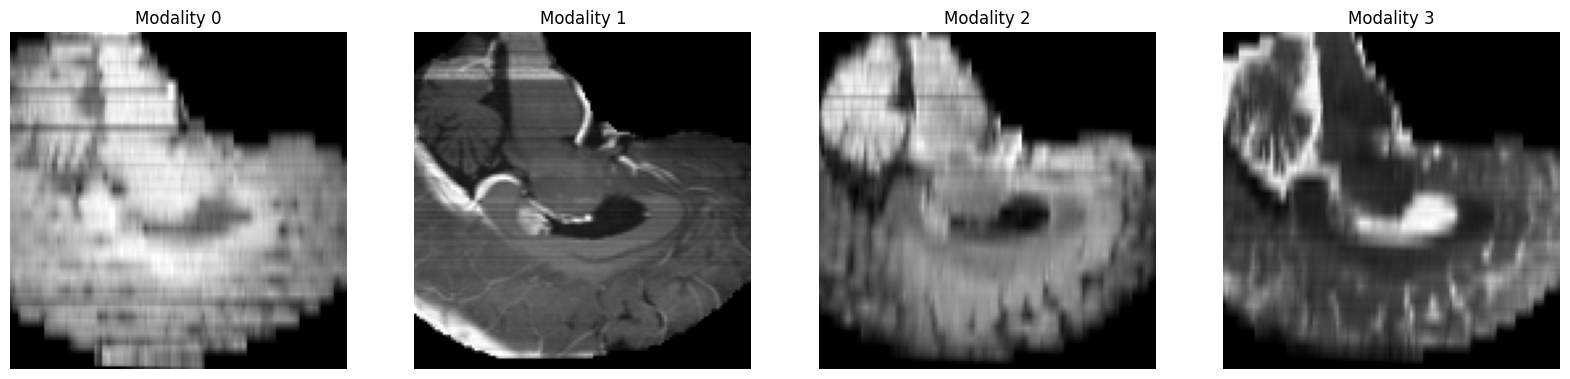

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(modalities[i, :, :, 64], cmap='gray')
    axes[i].set_title(f'Modality {i}')
    axes[i].axis('off')
plt.show()

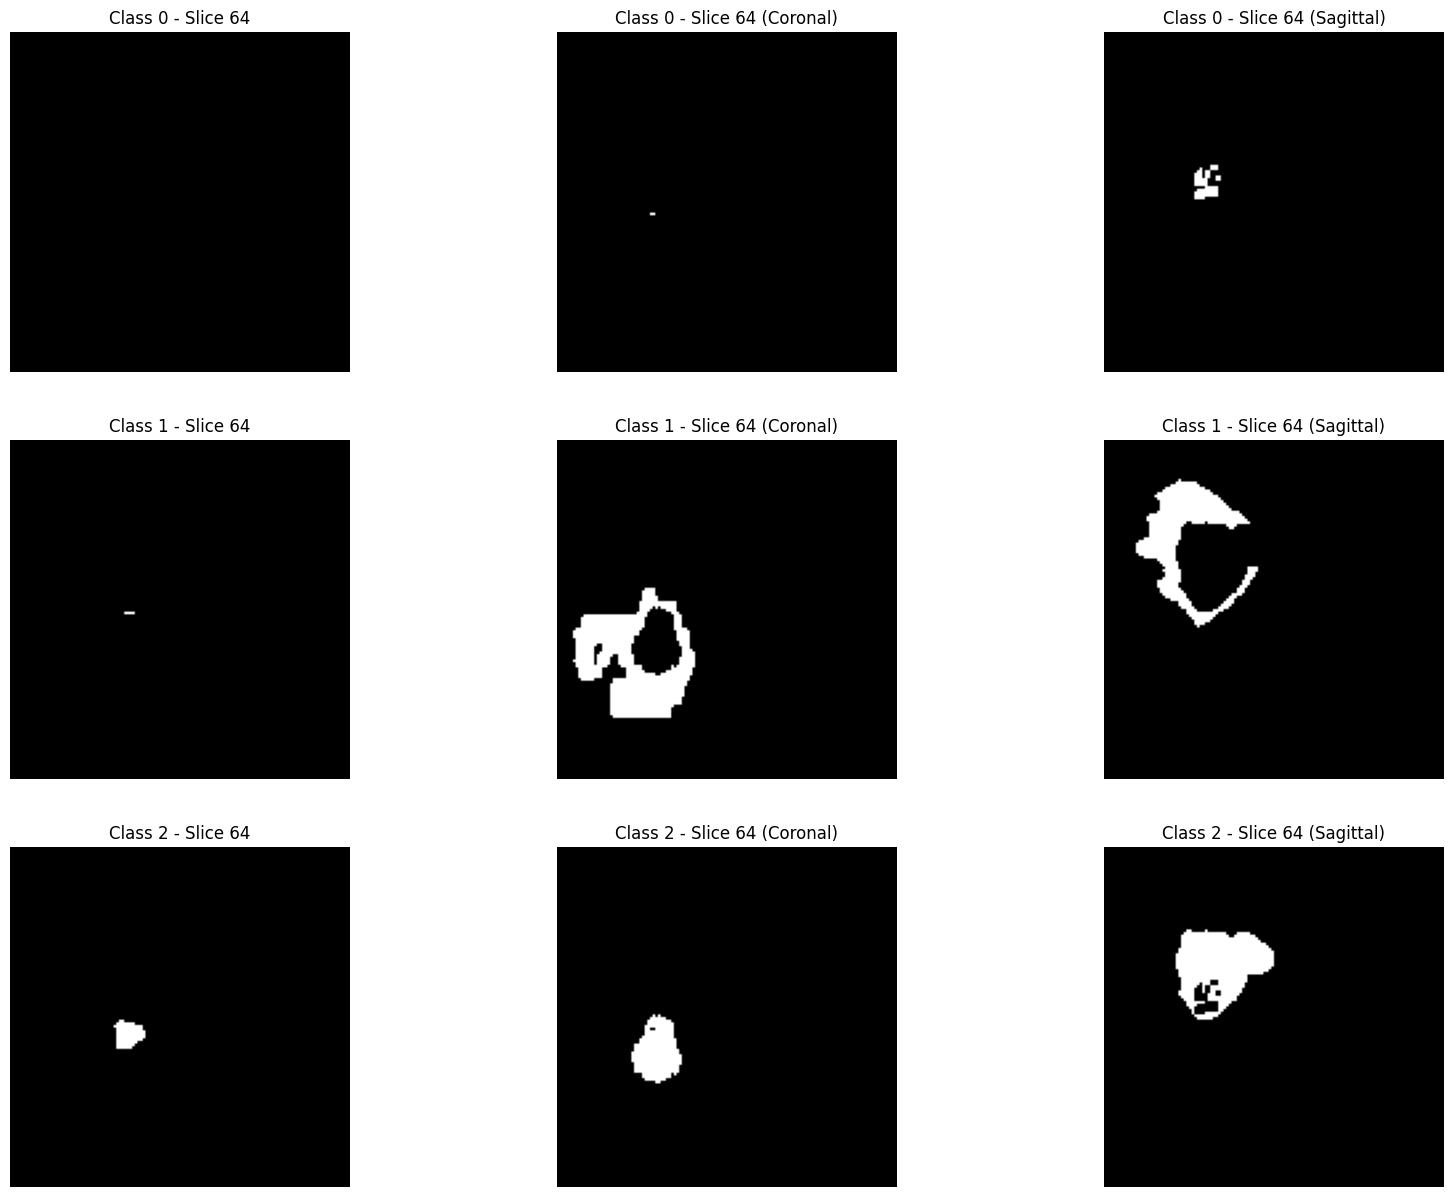

In [13]:
# Visualize the label data
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
for i in range(3):
    axes[i, 0].imshow(label[i, :, :, 64], cmap='gray')
    axes[i, 0].set_title(f'Class {i} - Slice 64')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(label[i, :, 64, :], cmap='gray')
    axes[i, 1].set_title(f'Class {i} - Slice 64 (Coronal)')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(label[i, 64, :, :], cmap='gray')
    axes[i, 2].set_title(f'Class {i} - Slice 64 (Sagittal)')
    axes[i, 2].axis('off')
plt.show()

### Train-test-split

In [15]:
# Path to the processed data directory
processed_data_dir = '/content/drive/MyDrive/BraTs/brats2023-processed'

# Assume each folder in the processed data directory represents a case
cases = [d for d in os.listdir(processed_data_dir) if os.path.isdir(os.path.join(processed_data_dir, d))]

# Split cases into train and validation (e.g., 80-20 split)
train_cases = cases[:int(len(cases) * 0.8)]
val_cases = cases[int(len(cases) * 0.8):]

# Create DataFrames
train_df = pd.DataFrame({'data_path': [os.path.join(processed_data_dir, c) for c in train_cases], 'case_name': train_cases})
val_df = pd.DataFrame({'data_path': [os.path.join(processed_data_dir, c) for c in val_cases], 'case_name': val_cases})

# Save to CSV
train_df.to_csv('/content/SegFormer3D/data/brats2023_seg/train.csv', index=False)
val_df.to_csv('/content/SegFormer3D/data/brats2023_seg/validation.csv', index=False)

## Training

In [21]:
%cd /content/SegFormer3D/experiments/brats_2023/my_experiment/
!accelerate launch --config_file ./gpu_accelerate.yaml run_experiment.py

/content/SegFormer3D/experiments/brats_2023/my_experiment
2024-07-10 11:08:06.666524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 11:08:06.666585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 11:08:06.668685: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 11:08:07.811637: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
wandb: Tracking run with wandb version 0.15.12
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


## Evaluation

## Visualizing results